In [1]:
!pwd

/Users/nico/panoseti/panoseti-software/cloud-detection/anomaly_detection


In [1]:
import sys, os
import logging, typing

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import torch
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
sys.path.append('../../util')
import panoseti_file_interfaces as pfi
import pff
from vae_model import *
from ph_dataset import *

In [2]:
# class PulseHeightDataset(torch.utils.data.Dataset):
#     """Interface for retrieving pulse-height images from a specific observing run."""
#     MAX_PH_VAL = 2**16 - 1  # Max PH pixel value. PH pixels are typically represented as uint16 values.
#     OUTLIER_CUTOFF = MAX_PH_VAL - 1000  # Value defining pixel outlier status

#     def __init__(self, config: typing.Dict, transform=None, target_transform=None, log_level=logging.ERROR):
#         super().__init__()
#         # Validate configuration dict
#         assert {'data_dir', 'run_dir', 'module_ids'}.issubset(set(config.keys()))
#         assert len(config['module_ids']) > 0
#         self.config = config
#         self.ori = pfi.ObservingRunInterface(config['data_dir'], config['run_dir'])
#         assert self.ori.obs_pff_files is not None
#         assert config['module_ids'] == 'all' or set(config['module_ids']).issubset(set(self.ori.obs_pff_files.keys()))
        
#         # Initialize PH frame generator
#         if config['module_ids'] == 'all':
#             self.dataset_module_ids = self.ori.obs_pff_files.keys()
#         else:
#             self.dataset_module_ids = config['module_ids']
#         self.ph_gen = self.ph_generator()

#         self.logger = logging.getLogger("PulseHeightDataset")
#         self.logger.setLevel(log_level)

#     def ph_generator(self):
#         """Returns a generator that yields PH frames."""
#         self.__ph_generators = {module_id: self.load_ph_data_lazy(module_id) for module_id in self.dataset_module_ids}
#         for module_id in self.dataset_module_ids:
#             for j in self.__ph_generators[module_id]:
#                 ph_img = j['img_data']
#                 del j['img_data']
#                 ph_img_clean, max_pixel_val = self.clean_ph_img(ph_img)
#                 if ph_img_clean is None:
#                     continue
#                 yield {'meta': j, 'img': ph_img_clean, 'max_pixel_val': max_pixel_val}
    
#     def load_ph_data_lazy(self, module_id: int):
#         """Sequentially yields PH frames from module_id."""
#         assert hasattr(self, 'ori')
#         if module_id not in self.ori.obs_pff_files:
#             print(f'No module with ID "{module_id}"\n'
#                   f'Available module_ids:\n\t{list(self.ori.obs_pff_files.keys())}')
#             return None
#         for ph_file in self.ori.obs_pff_files[module_id]["ph"]:
#             fname = ph_file["fname"]
#             fpath = "{0}/{1}/{2}".format(self.config['data_dir'], self.config['run_dir'], fname)
#             with open(fpath, 'rb') as fp:
#                 frame_iterator = self.ori.pulse_height_frame_iterator(fp, 1)
#                 for j, img in frame_iterator:
#                     j['wr_timestamp (s)'] = pff.wr_to_unix_decimal(j['pkt_tai'], j['pkt_nsec'], j['tv_sec'])
#                     j['unix_timestamp'] = pd.to_datetime(float(j['wr_timestamp (s)']), unit = 's', utc=True)
#                     j['img_data'] = img
#                     yield j

#     def clean_ph_img(self, ph_img: np.ndarray, outlier_strategy='zero', clip_z_score=5) -> typing.Tuple[int, int]:
#         """Set outlier pulse heigh pixel values to 0.
#         Arguments:
#             ph_img: raw pulse-height image
#             outlier_strategy: how to deal with outliers
#                 'zero' => set outliers to 0
#                 'clip' => clip outlier values to a max pixel value given by clip_z_score and inlier mean and standard deviations.
#         Returns: 2-element tuple:
#             idx 0: pulse-height frame after applying the specified outlier_strategy with pixels normalized to 0-1 
#             idx 1: maximum max_pixel_val, represented by the pixel value 1.0
#         """
#         # Remove outliers
#         assert outlier_strategy in ['zero', 'clip']
#         if outlier_strategy == 'zero':
#             ph_img_clean = ph_img.copy()
#             ph_img_clean[ph_img >= self.OUTLIER_CUTOFF] = 0
#         elif outlier_strategy == 'clip':
#             inlier_mean = np.mean(ph_img[ph_img < self.OUTLIER_CUTOFF])
#             inlier_std = np.std(ph_img[ph_img < self.OUTLIER_CUTOFF])
#             clip_max_pixel_val = inlier_mean + clip_z_score * inlier_std
#             ph_img_clean = ph_img.copy()
#             ph_img_clean = np.clip(ph_img_clean, 0, clip_max_pixel_val)
    
#         # PH image should not be all zeros
#         max_pixel_val = np.max(ph_img_clean)
#         if max_pixel_val == 0:
#             self.logger.warning('All PH pixels are zero')
#             return None, 0
#         ph_img_clean = ph_img_clean / max_pixel_val
#         return ph_img_clean, max_pixel_val
            
#     def get_ph_data(self, index: int):
#       try:
#           return next(self.ph_gen)
#       except StopIteration:
#           self.ph_gen = self.ph_generator()
#           return next(self.ph_gen)
            
#     def __getitem__(self, index: int) -> np.ndarray:
#         """Get PH frame at index. Note: currently index has no effect (TODO). index is required by the PyTorch abstract Dataset class."""
#         self.get_ph_data(index)['img']

#     def __len__(self) -> int:
#         total_ph_frames = 0
#         for module_id in self.dataset_module_ids:
#             for ph_file in self.ori.obs_pff_files[module_id]['ph']:
#                 total_ph_frames += ph_file['nframes']
#         return total_ph_frames

In [8]:
# ph_dataset_config = {
#     "data_dir": './test_data',
#     "run_dir": 'obs_Lick.start_2024-07-25T04:34:06Z.runtype_sci-data.pffd',
#     "module_ids": 'all',
# }

ph_dataset_config = {
    "data_dir": './test_data',
    "run_dir": 'obs_Lick.start_2023-10-12T04:28:34Z.runtype_eng-test.pffd',
    "module_ids": 'all',
}

ph_dataset = PulseHeightDataset(ph_dataset_config, log_level=logging.ERROR)

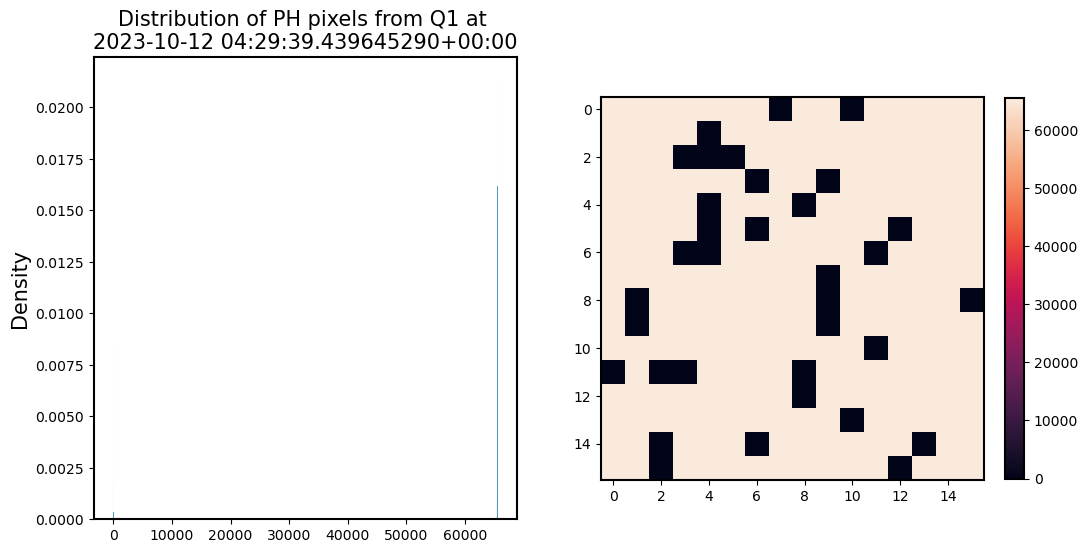

In [33]:
# PH data EDA: visualize PH image and the distribution of pixel values.
ph_data = ph_dataset.get_ph_data(0)

assert ph_data['img'] is not None
f, axs = plt.subplots(1, 2, figsize=(12, 6))
plot_ph_img(ph_data['img'], ph_data['meta'], ax=axs[1])
plot_ph_pixel_dist(ph_data['img'],  ph_data['meta'], ax=axs[0])

plt.show()

In [293]:
meta

{'quabo_num': 0,
 'pkt_num': 3546,
 'pkt_tai': 858,
 'pkt_nsec': 887378719,
 'tv_sec': 1721882421,
 'tv_usec': 887700,
 'wr_timestamp (s)': Decimal('1721882421.887378719'),
 'unix_timestamp': Timestamp('2024-07-25 04:40:21.887378693+0000', tz='UTC')}